Starting hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters Found: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

--- Final Model Performance on Test Data ---
Accuracy: 0.9264
ROC AUC Score: 0.9812

Confusion Matrix:
[[783   4]
 [ 68 123]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       787
           1       0.97      0.64      0.77       191

    accuracy                           0.93       978
   macro avg       0.94      0.82      0.86       978
weighted avg       0.93      0.93      0.92       978



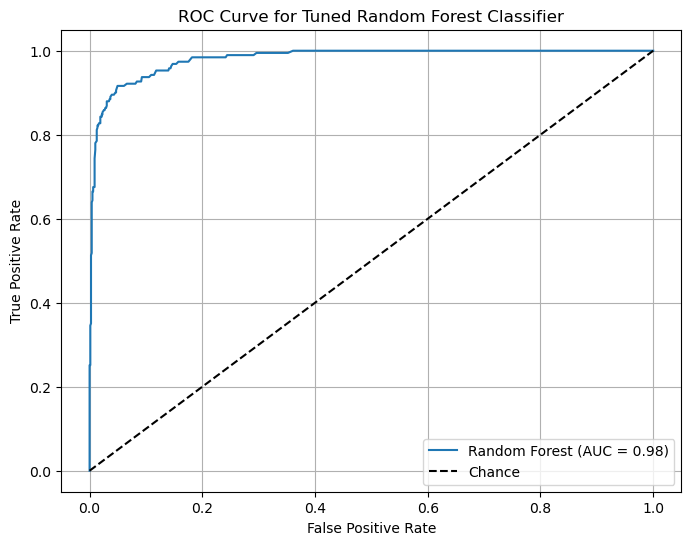

In [1]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# 2. Load and Initial Cleaning
df = pd.read_csv('Travel.csv')

# Correct inconsistencies in categorical data
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')

# 3. Handle Missing Values
# Impute with median for numerical columns and mode for categorical columns
df['Age'].fillna(df['Age'].median(), inplace=True)
df['DurationOfPitch'].fillna(df['DurationOfPitch'].median(), inplace=True)
df['NumberOfTrips'].fillna(df['NumberOfTrips'].median(), inplace=True)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)

df['TypeofContact'].fillna(df['TypeofContact'].mode()[0], inplace=True)
df['NumberOfFollowups'].fillna(df['NumberOfFollowups'].mode()[0], inplace=True)
df['PreferredPropertyStar'].fillna(df['PreferredPropertyStar'].mode()[0], inplace=True)
df['NumberOfChildrenVisiting'].fillna(df['NumberOfChildrenVisiting'].mode()[0], inplace=True)

# 4. Feature Engineering
# Combine visitor columns into a single feature
df['n_Visitors'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']

# Drop original and non-essential columns
df.drop(['CustomerID', 'NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)

# 5. Define Features (X) and Target (y)
X = df.drop('ProdTaken', axis=1)
y = df['ProdTaken']

# 6. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Create a Preprocessing Pipeline
# Identify categorical and numerical features
cat_feats = X.select_dtypes(include='object').columns
num_feats = X.select_dtypes(exclude='object').columns

# Define transformers for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feats),
        ('scaler', StandardScaler(), num_feats)
    ],
    remainder='passthrough'
)

# Apply the transformations
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 8. Hyperparameter Tuning with RandomizedSearchCV
print("Starting hyperparameter tuning with RandomizedSearchCV...")
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'min_samples_split': [2, 8, 15],
    'min_samples_leaf': [1, 2, 4]
}

rs_cv = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the random search model
rs_cv.fit(X_train_processed, y_train)

# Identify the best model found by the search
best_rf_model = rs_cv.best_estimator_
print(f"\nBest Parameters Found: {rs_cv.best_params_}")

# 9. Evaluate the Final, Tuned Model
print("\n--- Final Model Performance on Test Data ---")
y_pred = best_rf_model.predict(X_test_processed)
y_proba = best_rf_model.predict_proba(X_test_processed)[:, 1]

# Print metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Plot ROC Curve for the Final Model
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Random Forest Classifier')
plt.legend()
plt.grid(True)
plt.show()